In [1]:
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
def summarize_and_load(model_path):
    
    checkpt_dir = '/nfs0/BB/Hendrix_Lab/valejose/bioseq2seq/checkpoints/coding_noncoding/'
    checkpoint = torch.load(checkpt_dir+model_path, map_location='cpu')
    opts = checkpoint['opt']
    print(f'Loaded model {model_path} with parent {opts.checkpoint} and mode {opts.mode}')
    return checkpoint

shortcuts = {'B1' : 'bioseq2seq_1_Apr23_11-26-20/_step_12500.pt', # 95.77
'B2' : 'bioseq2seq_2_Apr23_11-26-17/_step_17000.pt', # 96.24
'B3' : 'bioseq2seq_3_Apr23_11-26-17/_step_7000.pt', # 95.74
'B4' : 'bioseq2seq_4_Apr23_11-26-17/_step_12500.pt', # 95.66
'EL1' : 'EDC_1_Apr25_14-52-01/_step_6000.pt', # 92.89
'EL2' : 'EDC_2_Apr25_14-52-01/_step_5000.pt', # 92.77
'EL3' : 'EDC_3_Apr25_14-52-01/_step_5000.pt', # 92.48
'EL4' : 'EDC_4_Apr25_14-52-01/_step_5000.pt', # 92.89
'ES1' : 'EDC_eq_1_Apr28_18-18-46/_step_1000.pt', # 89.67
'ES2' : 'EDC_eq_2_Apr28_18-18-46/_step_1000.pt', # 89.13
'ES3' : 'EDC_eq_3_Apr28_18-18-46/_step_1000.pt', # 89.25
'ES4' : 'EDC_eq_4_Apr28_18-18-46/_step_1000.pt'} # 90.12



In [103]:

def load_filter_layers(checkpoint,mode='abs'):
    
    global_filters = []
    has_next = True
    i_layer = 0
    while has_next:
        layer = f'encoder.fnet.{i_layer}.global_filter'
        if layer in checkpoint['model']:
            weight = checkpoint['model'][layer]
            if mode == 'abs':
                weight = weight.abs()
            else:
                weight = weight.angle()
                
            global_filters.append(weight[None])
            i_layer +=1
        else:
            has_next = False
            
    return global_filters
    

In [104]:
%matplotlib inline


In [105]:
def approximate_index(period,filter_size):
    frequency = 1.0 / period
    index = int(2*frequency*filter_size)
    return index

Loaded model EDC_4_Apr25_14-52-01/_step_5000.pt with parent None and mode EDC
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
torch.Size([6, 1, 101, 128])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
torch.Size([6, 1, 101, 128])


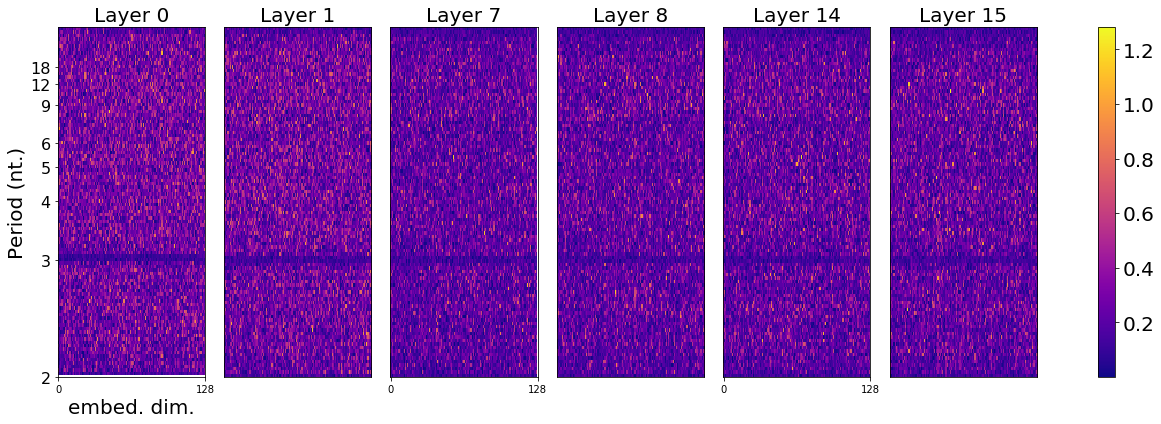

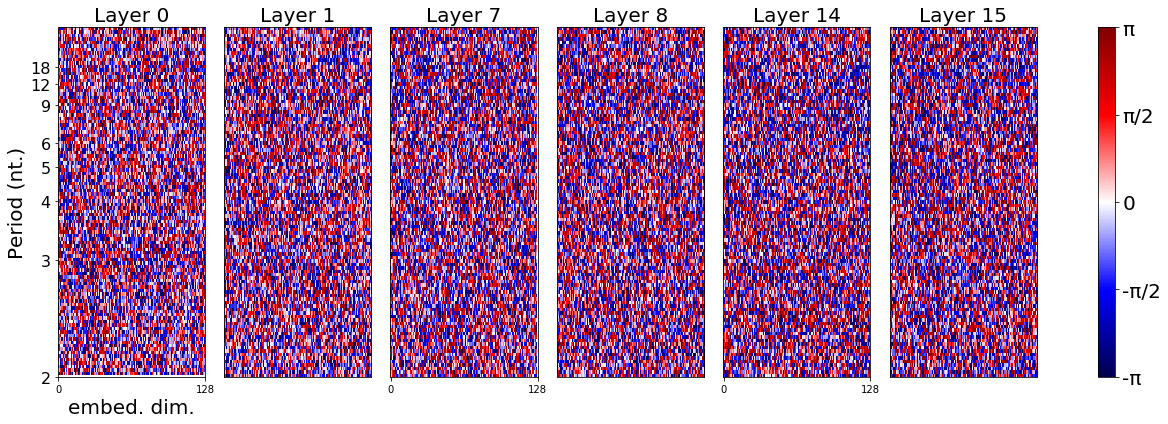

In [144]:
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_filters(global_filter_list,filename,mode):
    
    periods = [18,12,9,6,5,4,3,2]
    L = len(global_filter_list)
    fig, axs = plt.subplots(1,6,figsize=(18,6))
    
    index_list = list(range(L))
    print(index_list)
    mid = L // 2
    
    index_list = [0,1,mid-1,mid,L-2,L-1]
    total = torch.stack(global_filter_list,dim=0)
    index_tensor = torch.tensor(index_list)
    total = torch.index_select(total,0,index_tensor)
    print(total.shape)
    global_min = total.min().item()
    global_max = total.max().item()
    
    cmap = 'plasma' if mode == 'abs' else 'seismic'
    
    for j,i in enumerate(index_list):
        
        gf = global_filter_list[i].numpy().squeeze()
        im = axs[j].imshow(gf,cmap=cmap,aspect='auto',vmin=global_min,vmax=global_max)
        tick_locs = [approximate_index(p,gf.shape[0]) for p in periods]
        
        axs[j].set_title(f'Layer {i}',fontsize=20)
        if j == 0:
            axs[j].set_ylabel("Period (nt.)",fontsize=20)
            axs[j].set_xlabel("embed. dim.",fontsize=20)
            axs[j].set_yticks(tick_locs)
            axs[j].set_yticklabels(periods,fontsize=16)

        else:
            axs[j].set_yticks([])
            axs[j].set_yticklabels([])

        if j % 2 ==0:
            axs[j].set_xticks([0,gf.shape[1]])
        else:
            axs[j].set_xticks([])
    
    plt.tight_layout()

    if mode == 'phase':
        ticks=[-3.14,-1.57,0,1.57,3.14]
        cb = plt.colorbar(im,ax=axs.flat,ticks=ticks) 
        cb.ax.set_yticklabels(['-π','-π/2','0','π/2','π'])
    else:
        cb = plt.colorbar(im,ax=axs.flat) 

    cb.ax.tick_params(labelsize=20)
    plt.savefig(filename)

checkpoint = summarize_and_load(shortcuts['EL4'])
EDC_filters_abs = load_filter_layers(checkpoint,mode='abs')
plot_filters(EDC_filters_abs,'LFNet_filters_EDC_large_4_magnitude.svg',mode='abs')

EDC_filters_phase = load_filter_layers(checkpoint,mode='phase')
plot_filters(EDC_filters_phase,'LFNet_filters_EDC_large_4_phase.svg',mode='phase')


Loaded model bioseq2seq_2_Apr23_11-26-17/_step_17000.pt with parent None and mode bioseq2seq
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
torch.Size([6, 1, 126, 64])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
torch.Size([6, 1, 126, 64])


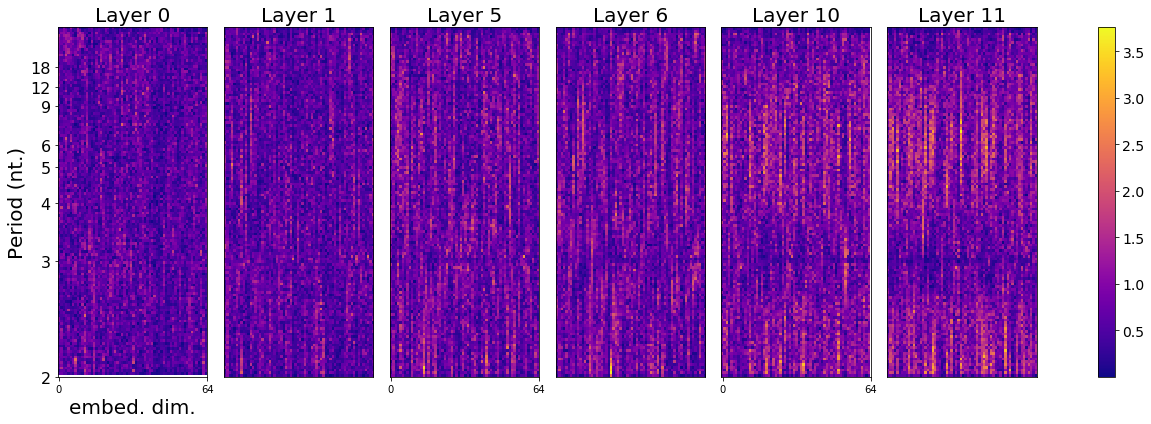

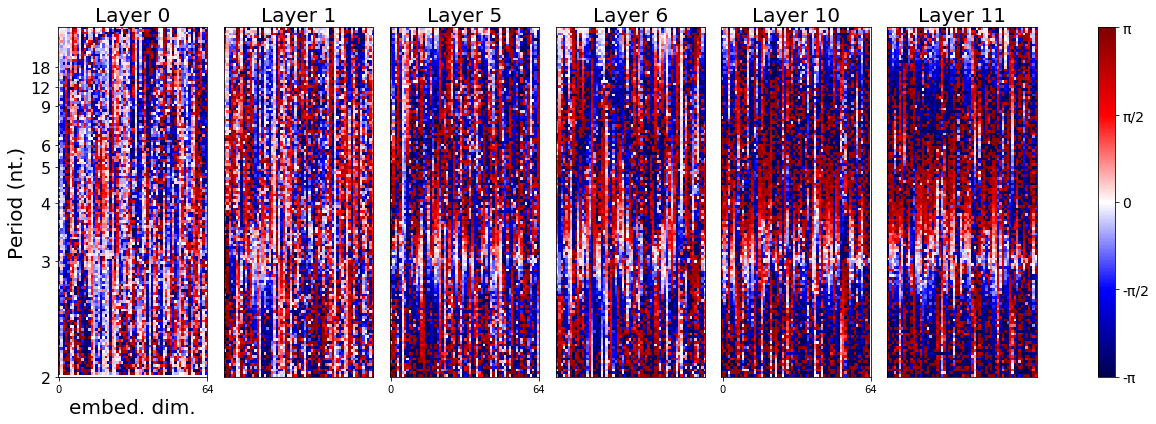

In [143]:
checkpoint = summarize_and_load(shortcuts['B2'])
bioseq2seq_filters_abs = load_filter_layers(checkpoint,mode='abs')
plot_filters(bioseq2seq_filters_abs,'LFNet_filters_bioseq2seq_2_magnitude.svg',mode='abs')

bioseq2seq_filters_phase = load_filter_layers(checkpoint,mode='phase')
plot_filters(bioseq2seq_filters_phase,'LFNet_filters_bioseq2seq_2_phase.svg',mode='phase')